In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Read the dataset
data = pd.read_csv('/datasets/eteplygina/combined_data.csv')

modified_groups = []
grouped_data = data.groupby('id')
# Iterate over each group
for _, group in grouped_data:
    # Calculate 'shock_index_times_age' for the current group
    group['shock_index_times_age'] = (group['heartrate'] / group['sbp']) * group['age']
    # Append the modified group to the list
    modified_groups.append(group)

# Concatenate the modified groups back into a single DataFrame
modified_data = pd.concat(modified_groups)

# Group the data by ID
grouped_data = modified_data.groupby('id')

# Initialize lists to store features and labels
all_features = []
all_labels = []

# Iterate over each group (ID)
for _, group in grouped_data:
    # Interpolate missing values in vital sign measurements
    vital_signs = ['heartrate', 'sbp', 'dbp', 'mbp', 'respiration', 'temperature', 'spo2']
   
    # Calculate features for each vital sign measurement
    features = {'id': group['id'].iloc[0]}  
    
    # Create engineered features
    for vital_sign in vital_signs:
        features[f'mean_{vital_sign}'] = group[vital_sign].mean()
        features[f'median_{vital_sign}'] = group[vital_sign].median()
        features[f'max_{vital_sign}'] = group[vital_sign].max()
        features[f'min_{vital_sign}'] = group[vital_sign].min()
        features[f'std_{vital_sign}'] = group[vital_sign].std()
    
    features['min_shock_index_times_age'] = group['shock_index_times_age'].min()
    features['max_shock_index_times_age'] = group['shock_index_times_age'].max()
    features['overall_change_shock_index_times_age'] = group['shock_index_times_age'].iloc[-1] - group['shock_index_times_age'].iloc[0]
    # Calculate overall change in vital sign values
    for vital_sign in vital_signs:
        features[f'overall_change_{vital_sign}'] = group[vital_sign].iloc[-1] - group[vital_sign].iloc[0]
    
    

    all_features.append(features)
    label = group['label'].iloc[0]
    all_labels.append(label)

# Convert the lists of dictionaries to DataFrames
features_df = pd.DataFrame(all_features)
features_df.interpolate(method='linear', inplace=True)
labels_df = pd.DataFrame({'id': features_df['id'], 'label': all_labels})

print(features_df)
print(labels_df)

             id  mean_heartrate  median_heartrate  max_heartrate  \
0      30000213       82.955882              83.0           91.0   
1      30001148       68.045714              65.0           95.0   
2      30001336       62.573446              62.5           76.0   
3      30001396       81.705882              84.0           93.0   
4      30001471       82.473545              81.5          107.0   
...         ...             ...               ...            ...   
15718  39996870       71.167814              62.0          131.0   
15719  39997753       77.853035              76.0           97.0   
15720  39998138       37.162500              35.0           71.0   
15721  39999286      113.095238             112.0          127.0   
15722  39999810       65.178161              63.0           93.0   

       min_heartrate  std_heartrate    mean_sbp  median_sbp  max_sbp  min_sbp  \
0               66.0       6.358527  134.676471       133.0    179.0    116.0   
1               61.0 

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Split the dataset into features (X) and labels (y)
X = features_df.drop(columns=['id'])  # Drop the 'id' column as it's not a feature
y = labels_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Class distribution in training set:")
print(y_train.value_counts())

# Check the class distribution in the test set
print("\nClass distribution in test set:")
print(y_test.value_counts())

# Define custom sample weights based on 1:4 ratio (neg:pos)
class_ratio = 4  # ratio of negative to positive samples (1:4)
sample_weights = np.where(y_train == 1, class_ratio, 1)



Class distribution in training set:
0    10012
1     2566
Name: label, dtype: int64

Class distribution in test set:
0    2524
1     621
Name: label, dtype: int64


[I 2024-06-26 01:33:00,726] A new study created in memory with name: no-name-50bfa12f-bc6e-4af0-a89b-967418ab2f8d
[I 2024-06-26 01:33:14,816] Trial 0 finished with value: 0.6215780998389694 and parameters: {'max_depth': 6, 'learning_rate': 0.17341893248818024, 'n_estimators': 109}. Best is trial 0 with value: 0.6215780998389694.
[I 2024-06-26 01:33:25,967] Trial 1 finished with value: 0.6892109500805152 and parameters: {'max_depth': 7, 'learning_rate': 0.03280520433394175, 'n_estimators': 75}. Best is trial 1 with value: 0.6892109500805152.
[I 2024-06-26 01:33:40,800] Trial 2 finished with value: 0.6038647342995169 and parameters: {'max_depth': 8, 'learning_rate': 0.045536449494716115, 'n_estimators': 87}. Best is trial 1 with value: 0.6892109500805152.
[I 2024-06-26 01:34:15,563] Trial 3 finished with value: 0.46537842190016104 and parameters: {'max_depth': 9, 'learning_rate': 0.27002427906003845, 'n_estimators': 180}. Best is trial 1 with value: 0.6892109500805152.
[I 2024-06-26 01:3

Best Hyperparameters: {'max_depth': 2, 'learning_rate': 0.09488243176474118, 'n_estimators': 141}
Best Model Recall: 0.7648953301127214
Accuracy: 0.7809220985691574
Precision: 0.46660117878192536
Recall: 0.7648953301127214
F1 Score: 0.5796217205613179
Confusion Matrix:
[[1981  543]
 [ 146  475]]


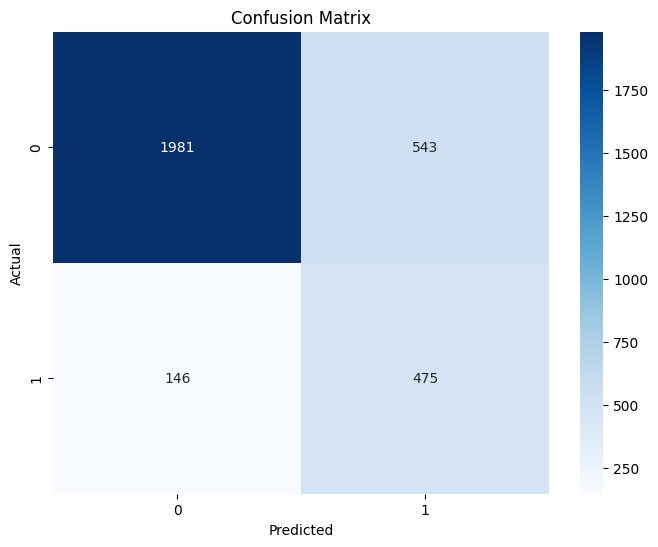

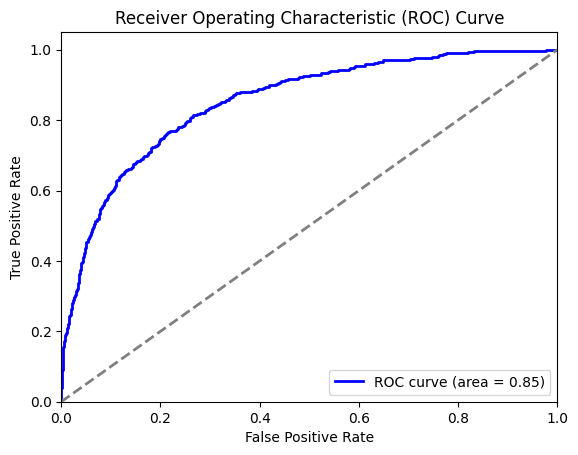

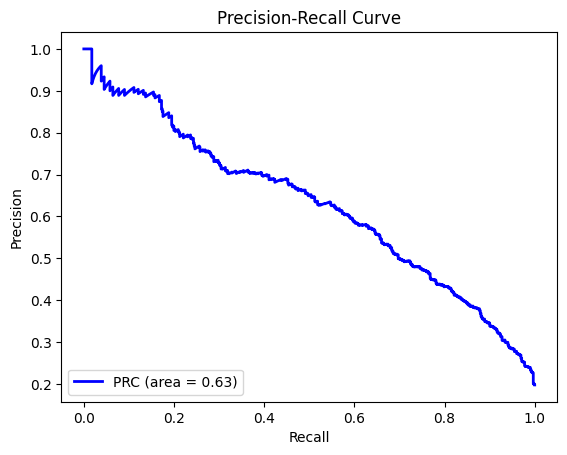

                                 Feature  Importance
8                                min_sbp    0.222981
27                       max_temperature    0.175679
29                       std_temperature    0.134411
36             max_shock_index_times_age    0.056665
25                      mean_temperature    0.043353
31                           median_spo2    0.036279
2                          max_heartrate    0.029454
11                            median_dbp    0.026635
30                             mean_spo2    0.024388
4                          std_heartrate    0.024234
44                   overall_change_spo2    0.021704
23                       min_respiration    0.021096
26                    median_temperature    0.020001
9                                std_sbp    0.019739
32                              max_spo2    0.019704
34                              std_spo2    0.014523
10                              mean_dbp    0.014173
12                               max_dbp    0.

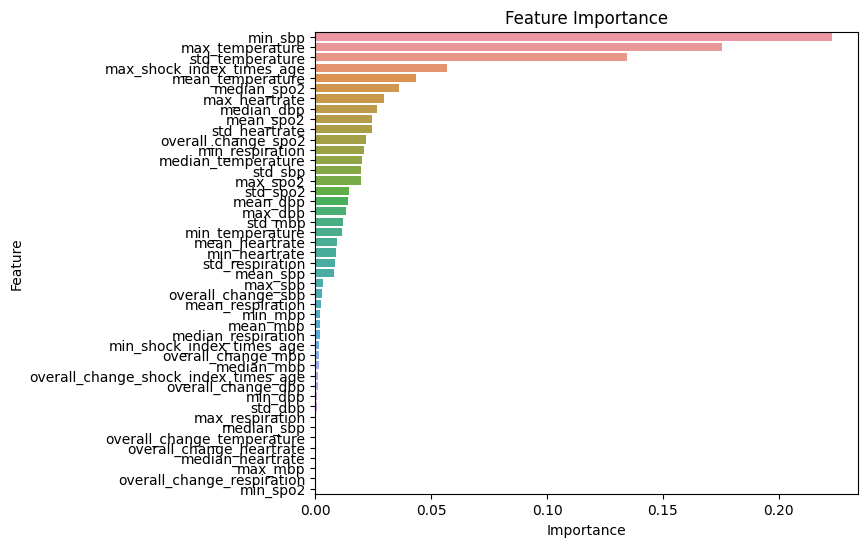

In [28]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import keras_tuner as kt
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    
    model = GradientBoostingClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    
    # Train the model
    model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    # Predict on the validation set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred)
    
    return recall

# Create the Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

# Train the best model
best_model = GradientBoostingClassifier(
    max_depth=best_hyperparams['max_depth'],
    learning_rate=best_hyperparams['learning_rate'],
    n_estimators=best_hyperparams['n_estimators']
)
best_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Evaluate the best model
y_pred = best_model.predict(X_test_scaled)
recall = recall_score(y_test, y_pred)
print(f"Best Model Recall: {recall}")

# Additional evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (area = {prc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Feature importance
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top features
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(7, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

Trial 50 Complete [00h 00m 34s]
val_recall: 0.6312399355877617

Best val_recall So Far: 0.7584541062801933
Total elapsed time: 00h 13m 49s
GradientBoostingClassifier with max_depth=3, learning_rate=0.19680535957137502, n_estimators=50
Best Model Recall: 0.7584541062801933
Accuracy: 0.7847376788553259
Precision: 0.47194388777555113
Recall: 0.7584541062801933
F1 Score: 0.5818406423718345
Confusion Matrix:
[[1997  527]
 [ 150  471]]


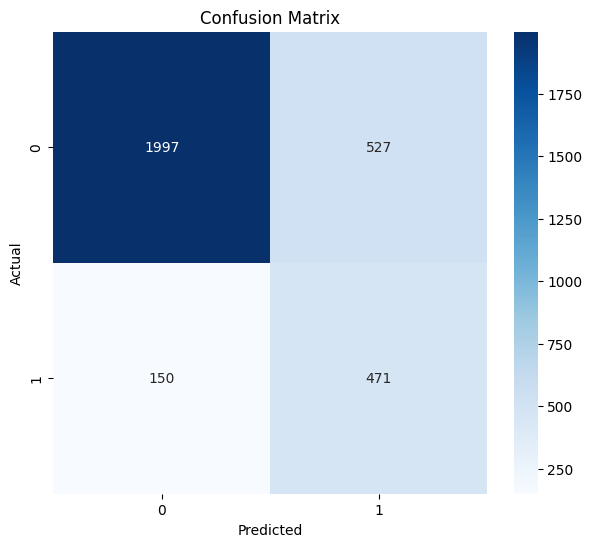

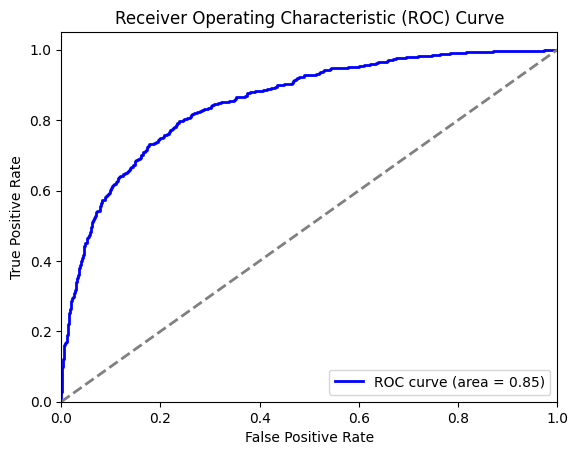

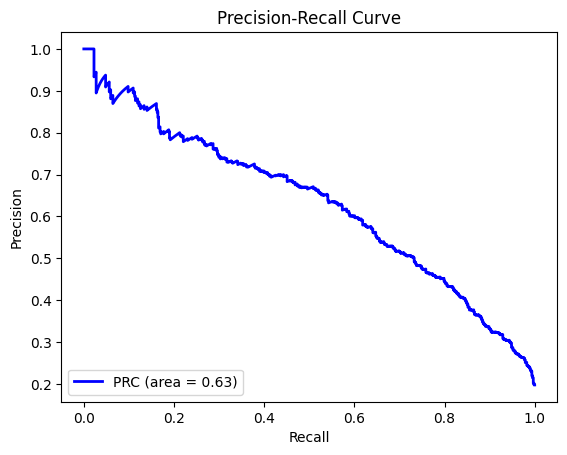

In [21]:
#Keras-tuner
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
# import keras_tuner as kt
# import tensorflow as tf
# import joblib
# import matplotlib.pyplot as plt
# import seaborn as sns

# class GradientBoostingClassifierWrapper(tf.keras.Model):
#     def __init__(self, max_depth, learning_rate, n_estimators):
#         super(GradientBoostingClassifierWrapper, self).__init__()
#         self.model = GradientBoostingClassifier(
#             max_depth=max_depth,
#             learning_rate=learning_rate,
#             n_estimators=n_estimators
#         )

#     def fit(self, X, y, sample_weight=None, validation_data=None, **kwargs):
#         self.model.fit(X, y, sample_weight=sample_weight)
#         val_X, val_y = validation_data
#         val_predictions = self.model.predict(val_X)
#         val_recall = recall_score(val_y, val_predictions)
#         # Return metrics in the format expected by Keras Tuner
#         return {"val_recall": val_recall}
    
#     def predict(self, X):
#         return self.model.predict(X)
    
#     def predict_proba(self, X):
#         return self.model.predict_proba(X)
    
#     def save(self, filepath):
#         joblib.dump(self.model, filepath)
    
#     def load(self, filepath):
#         self.model = joblib.load(filepath)

#     def summary(self):
#         print(f"GradientBoostingClassifier with max_depth={self.model.max_depth}, learning_rate={self.model.learning_rate}, n_estimators={self.model.n_estimators}")

# # Define the model building function for Keras Tuner
# def build_model(hp):
#     max_depth = hp.Int('max_depth', min_value=2, max_value=10, step=1)
#     learning_rate = hp.Float('learning_rate', min_value=0.01, max_value=0.3, sampling='log')
#     n_estimators = hp.Int('n_estimators', min_value=50, max_value=200, step=50)
    
#     model = GradientBoostingClassifierWrapper(
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         n_estimators=n_estimators
#     )
    
#     return model

# # Initialize the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective=kt.Objective('val_recall', direction='max'),  # Match the key returned by fit method
#     max_trials=50,
#     directory='my_dir',
#     project_name='gbc_tuning'
# )

# # Run the search
# tuner.search(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), sample_weight=sample_weights)

# # Manually retrieve and save the best model
# best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
# best_model = build_model(best_trial.hyperparameters)
# best_model.fit(X_train_scaled, y_train, sample_weight=sample_weights, validation_data=(X_test_scaled, y_test))

# # Print the best model summary
# best_model.summary()

# # Evaluate the best model
# y_pred = best_model.predict(X_test_scaled)
# recall = recall_score(y_test, y_pred)
# print(f"Best Model Recall: {recall}")

# # Additional evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print the evaluation metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print("Confusion Matrix:")
# print(conf_matrix)

# # Plot confusion matrix
# plt.figure(figsize=(7, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# # ROC AUC
# y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

# # Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# prc_auc = auc(recall, precision)

# # Plot Precision-Recall Curve
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (area = {prc_auc:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="lower left")
# plt.show()



In [17]:
# # Check for NaN values in the DataFrame
# nan_columns = features_df.columns[features_df.isna().any()].tolist()
# print("Columns with NaN values:", nan_columns)


Columns with NaN values: []


In [3]:
# best_model = GradientBoostingClassifier(max_depth=3, learning_rate=0.1673698241350006, n_estimators=50)
# best_model.fit(X_train_scaled, y_train,sample_weight=sample_weights)

GradientBoostingClassifier(learning_rate=0.1673698241350006, n_estimators=50)

Accuracy: 0.7783783783783784
Precision: 0.462671905697446
Recall: 0.7584541062801933
F1-score: 0.5747406955460647


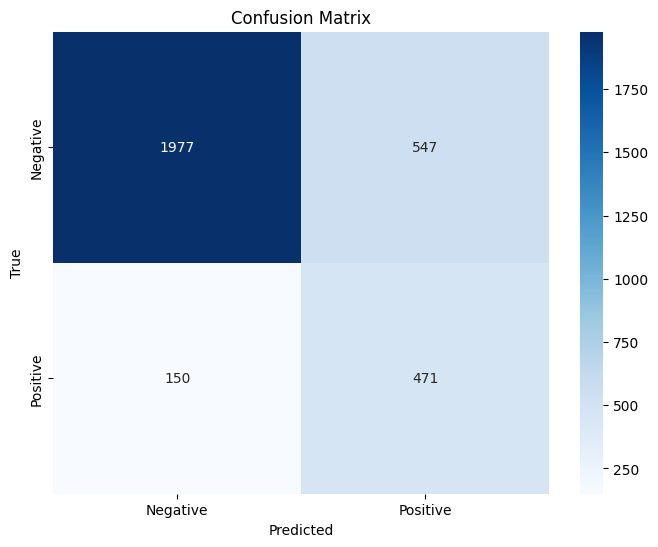

True Positives: 471
True Negatives: 1977
False Positives: 547
False Negatives: 150


In [4]:
# # Predict on the test set
# y_pred = best_model.predict(X_test_scaled)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print the evaluation metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)


# # Extract TP, TN, FP, FN
# TN, FP, FN, TP = conf_matrix.ravel()

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Print TP, TN, FP, FN
# print("True Positives:", TP)
# print("True Negatives:", TN)
# print("False Positives:", FP)
# print("False Negatives:", FN)


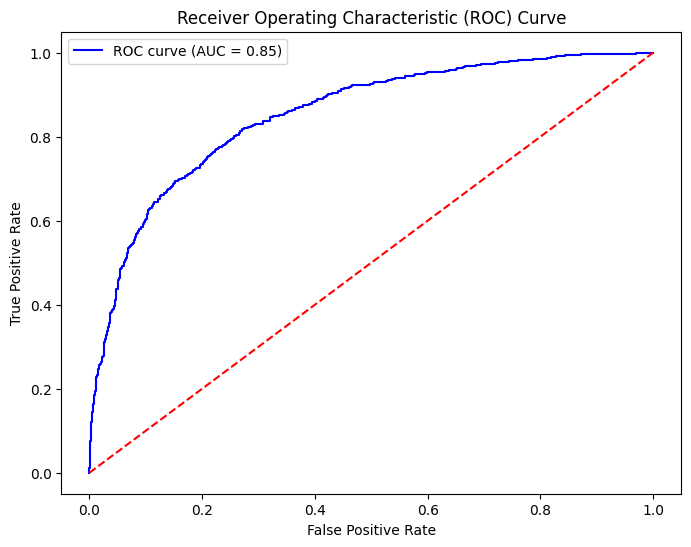

In [5]:
# # Calculate the ROC curve
# y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.show()


                                 Feature  Importance
8                                min_sbp    0.216696
27                       max_temperature    0.152263
29                       std_temperature    0.143299
36             max_shock_index_times_age    0.056925
25                      mean_temperature    0.045867
31                           median_spo2    0.041266
2                          max_heartrate    0.027331
4                          std_heartrate    0.026256
44                   overall_change_spo2    0.024932
23                       min_respiration    0.021728
11                            median_dbp    0.020727
9                                std_sbp    0.019541
30                             mean_spo2    0.019294
32                              max_spo2    0.017889
26                    median_temperature    0.016763
3                          min_heartrate    0.014920
34                              std_spo2    0.014868
10                              mean_dbp    0.

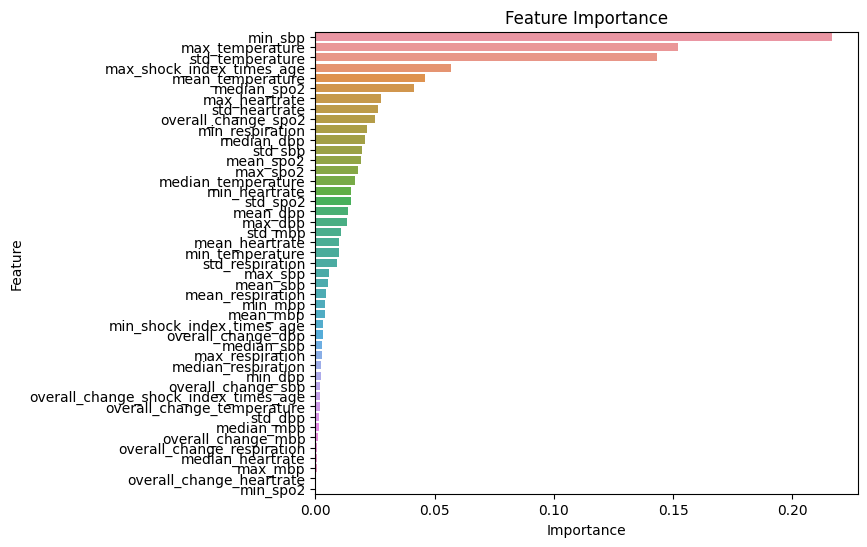

In [6]:
# # Feature importance
# feature_importances = best_model.feature_importances_

# # Create a DataFrame to display feature importances
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# # Display the top features
# print(feature_importance_df)

# # Plot feature importance
# plt.figure(figsize=(7, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('Feature Importance')
# plt.show()